In [5]:
import jax.numpy as jnp
import numpy as np
import jax.random as random

from data import random_walk
from nf import AmortizedNormalizingFlow
from loss_models import loss_fn_SBL, NF_library

from modax.training import create_update, train_max_iter
from modax.models.models import DeepmodBase
from modax.layers.regression import LeastSquares
from flax import optim
from deepymod.analysis import load_tensorboard
from functools import partial

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from natsort import natsorted
from matplotlib.gridspec import GridSpec

%load_ext autoreload
%autoreload 2

In [2]:
key = random.PRNGKey(42)

# Creating data

In [22]:
def dataset(key, n_steps, n_walkers, D, v, dt, sigma0, x0):
    def initial_condition(loc, width, key, shape):
        key1, key2 = random.split(key)
        ini_1 = loc[0] + width[0] * random.normal(key1, (shape[0], int(shape[1] /2)))
        ini_2 = loc[1] + width[1] * random.normal(key2, (shape[0], int(shape[1] /2)))
        return jnp.concatenate([ini_1, ini_2], axis=1)
    
    ini = partial(initial_condition, x0, sigma0)
    locs, t = random_walk(key, ini, n_steps, n_walkers, D, v, dt=dt)
    return jnp.expand_dims(locs, -1), jnp.expand_dims(t, -1)

In [23]:
D = 1.5
v = 0.5
dt= 0.1
sigma0 = [1.5, 0.5]
x0=[-5, 1]
n_steps = 50
n_walkers = 100

X, t = dataset(key, n_steps, n_walkers, D, v, dt, sigma0, x0)
t+=1
X_true = np.array(dataset(key, n_steps, 10000, D, v, dt, sigma0, x0)[0])

In [24]:
X.shape

(51, 100, 1)

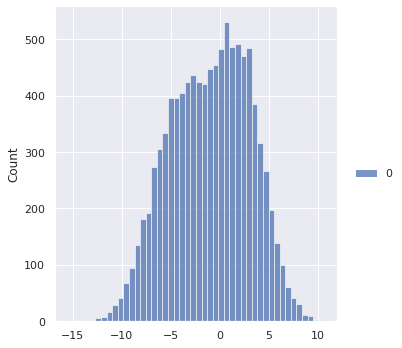

In [25]:
sns.displot(X_true[20], bins='auto')

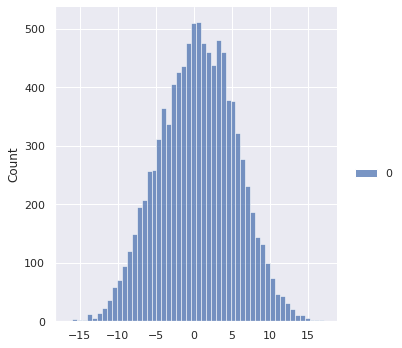

In [26]:
sns.displot(X_true[50])

def dataset(key, n_steps, n_walkers, D, v, dt, sigma0, x0):
    def initial_condition(loc, width, key, shape):
        return loc + width * random.normal(key, shape)
    
    ini = partial(initial_condition, x0, sigma0)
    locs, t = random_walk(key, ini, n_steps, n_walkers, D, v, dt=dt)
    return jnp.expand_dims(locs, -1), jnp.expand_dims(t, -1)

D = 1.5
v = 0.5
dt= 0.1
sigma0 =0.5
x0=-1
n_steps = 50
n_walkers = 100

X, t = dataset(key, n_steps, n_walkers, D, v, dt, sigma0, x0)
t += 1.0 # add an offset otherwise it has lots of issues with t=0

X.shape

In [27]:
model = DeepmodBase(AmortizedNormalizingFlow, ([30, 30], 10, ), NF_library, (), LeastSquares, ())
optimizer_def = optim.Adam(learning_rate=2e-3, beta1=0.99, beta2=0.99)

In [2]:
variables = model.init(key, (X, t))
state, params = variables.pop("params")
state = (state, {"prior_init": None})  # adding prior to state
optimizer = optimizer_def.create(params)
update_fn = create_update(loss_fn_SBL, (model, (X, t)))

NameError: name 'model' is not defined

In [1]:
optimizer, state = train_max_iter(update_fn, optimizer, state, 20000)

NameError: name 'train_max_iter' is not defined

In [12]:
jnp.save('trained_model', optimizer.target)

In [13]:
# Sampling on a grid for nice pictures
x = jnp.linspace(-10, 10, 200)
x_grid = jnp.meshgrid(x, t.squeeze())[0][:, :, None]

model_state, loss_state = state
log_p, dt, theta, coeffs = model.apply({'params': optimizer.target, **model_state}, (x_grid, t))
p = jnp.exp(log_p).reshape(x_grid.shape[:2])

In [14]:
# Making analytical solution
def adv_diff(x, t, v, D, sigma0, x0):
    return  (2 * jnp.pi * sigma0 ** 2 + 4 * jnp.pi * D * t) ** (-1 / 2) * jnp.exp(
        -((x - x0 - v * t) ** 2) / (2 * sigma0 ** 2 + 4 * D * t)
    )

p_true = adv_diff(x_grid.squeeze(), jnp.ones_like(x_grid.squeeze()) * (t-1), v, D, sigma0, x0) # undo t+1 offset

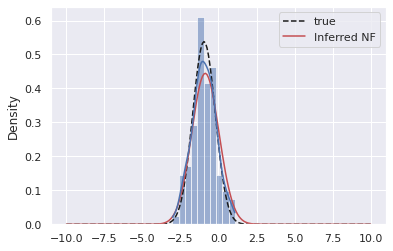

In [15]:
frame = 1
plt.plot(x, p_true[frame, :], 'k--', label='true')
plt.plot(x, p[frame, :], 'r', label='Inferred NF')
sns.histplot(X[frame, :], bins='auto', stat='density', kde=True)
plt.legend()

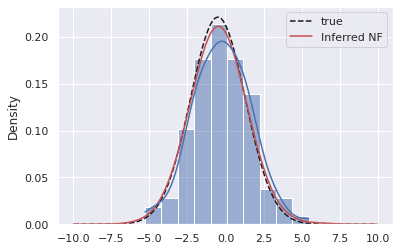

In [16]:
frame = 10
plt.plot(x, p_true[frame, :], 'k--', label='true')
plt.plot(x, p[frame, :], 'r', label='Inferred NF')
sns.histplot(X[frame, :], bins='auto', stat='density', kde=True)
plt.legend()

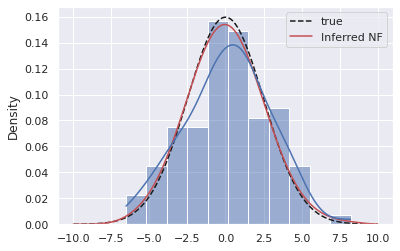

In [17]:
frame = 20
plt.plot(x, p_true[frame, :], 'k--', label='true')
plt.plot(x, p[frame, :], 'r', label='Inferred NF')
sns.histplot(X[frame, :], bins='auto', stat='density', kde=True)
plt.legend()

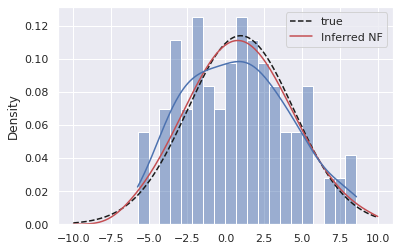

In [18]:
frame = 40
plt.plot(x, p_true[frame, :], 'k--', label='true')
plt.plot(x, p[frame, :], 'r', label='Inferred NF')
sns.histplot(X[frame, :], bins=20, stat='density', kde=True)
plt.legend()

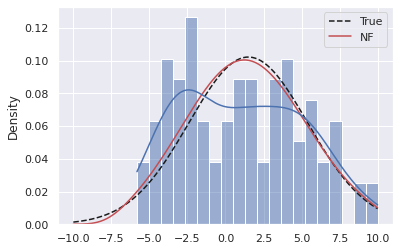

In [22]:
frame = 55
plt.plot(x, p_true[frame, :], 'k--', label='True')
plt.plot(x, p[frame, :], 'r', label='NF')
sns.histplot(X[frame, :], bins=20, stat='density', kde=True)
plt.legend()

<AxesSubplot:>

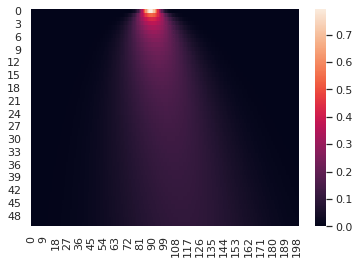

In [23]:
sns.heatmap(p_true)

<AxesSubplot:>

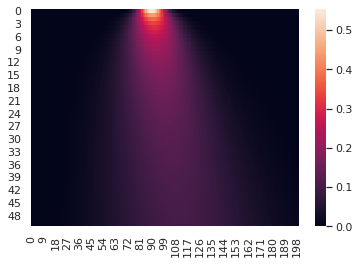

In [24]:
sns.heatmap(p)

# Plot

In [7]:
# settings
sns.set(context='paper', style='white')
col_width = 5.5 # neurips style column width in inches
font_size = 8
plt.rcParams.update({'font.size': 8})

In [8]:
df = load_tensorboard('runs/May17_18-40-24_workstationgj/')

In [9]:
prior_keys = natsorted([key for key in df.keys() if key.find('alpha') == 0])
coeff_keys = natsorted([key for key in df.keys() if key.find('coeff') == 0])

NameError: name 'x' is not defined

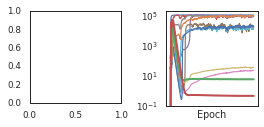

In [10]:
fig = plt.figure(constrained_layout=True, figsize=(0.9 * col_width, 0.3 * col_width))
gs = GridSpec(2, 3, figure=fig)

ax = fig.add_subplot(gs[:, 2])
ax.plot(df[prior_keys].ewm(alpha=0.1).mean())
ax.plot(df[prior_keys[1]].ewm(alpha=0.1).mean(), lw=2)
ax.plot(df[prior_keys[2]].ewm(alpha=0.1).mean(), lw=2)
ax.set_yscale('log')
ax.set_xticks([])
ax.set_xlabel('Epoch')
ax.set_ylim([1e-1, 2e5])



ax = fig.add_subplot(gs[0, 1])
frame = 15
ax.plot(x, p_true[frame, :], 'k--')
ax.plot(x, p[frame, :], 'r')
sns.histplot(X[frame, :], bins=20, ax=ax, stat='density', legend=False)
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-10, 10])


ax = fig.add_subplot(gs[1, 1])
frame = 45
ax.plot(x, p_true[frame, :], 'k--', label='Truth')
ax.plot(x, p[frame, :], 'r', label='NF')
sns.histplot(X[frame, :], ax=ax, bins=20, stat='density', legend=True)
ax.set_ylabel('')
ax.set_yticks([])
ax.set_xlim([-10, 10])

ax = fig.add_subplot(gs[:, 0])
sns.heatmap(p_true, ax=ax, xticklabels=[], yticklabels=[], cbar=False)
ax.axhline(45, linestyle='--', color='r')
ax.axhline(15, linestyle='--', color='r')
ax.set_xlabel('space')
ax.set_ylabel('time')
plt.savefig('NF.pdf', bbox_inches='tight', pad_inches=0.0)

In [11]:
t[55]

NameError: name 't' is not defined

In [12]:
frame = 55
plt.plot(x, p_true[frame, :], 'k--', label='True')
plt.plot(x, p[frame, :], 'r', label='NF')
sns.histplot(X[frame, :], bins=20, stat='density')
plt.legend()

NameError: name 'x' is not defined

In [13]:
frame = 20
plt.plot(x, p_true[frame, :], 'k--', label='True')
plt.plot(x, p[frame, :], 'r', label='NF')
sns.histplot(X[frame, :], bins=20, stat='density')
plt.legend()

NameError: name 'x' is not defined

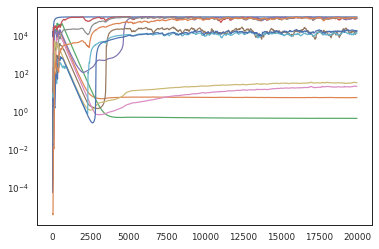

In [14]:
plt.semilogy(df[prior_keys].ewm(alpha=0.1).mean())

In [15]:
p = jnp.load('inferred_density.npy')

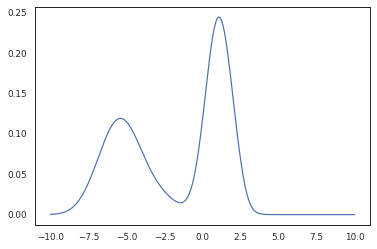

In [19]:
frame = 0
#sns.displot(X_true[frame], stat='density', bins='auto')
#sns.displot(X[frame], stat='density', bins='auto')
plt.plot(np.linspace(-10, 10, 200), p[frame, :])
#plt.plot(p[40, :])

In [7]:
p.shape

(51, 200)